In [1]:
import sys
import os
from os.path import join
import numpy as np
import pandas as pd
import h5py
import imageio
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import proplot as pplt
import energyVS06 as energy

pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

In [2]:
datadir = './Diagnostics/Data/Measurements/2022-04-26/'
os.listdir(datadir)

['.DS_Store', '220426155714-x2d-slit.h5', '220426160727-y1d-vs06.h5']

In [29]:
# HZ34a scan
filename = '220426160727-y1d-vs06.h5'
L = 8.0036 - 6.13006

## HZ34b scan
# filename =''
# L = 8.0036 - 6.90450

print(f'L = {L:.3f}')

# Slit-slit scan, L = 0.775
cam = 'cam34'
cam_prof_y = f'{cam}_ProfileY'
cam_image = f'{cam}_Image'
pix2mm = 0.05  # cam34 at zoom x1
ny = 512  # number of y pixels
nx = 612  # number of x pixels

L = 1.874


In [4]:
file = h5py.File(join(datadir, filename), 'r')

In [5]:
# Errors and warnings from log
for i in range(file['log'].size):
    if not(file['/log'][i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(file['/log'][0, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {file['log'][i, 'message']}")

# Configuration data
for key in file['/config'].keys():
    print(f"{key}")
    print("--------------")
    for name in file['/config'][key].dtype.names:
        print(f"{name}: {file['config'][key][name]}")
    print()

environment
--------------
timestamp: [1.65100365e+09]
user: [b'46h']
host: [b'btf-diag-app1.ics.sns.gov']
cmd_line: [b'scan1d/y1d-vs06.py']
work_dir: [b'/home/46h/se-template']

metadata
--------------
timestamp: [1.65100367e+09]
Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
RFTF_TM:Gate_BeamOn:RR: [5.]
BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55000019]
BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
BTF_MEBT_Mag:PS_QH33:I_Set: [5.0999999]
BTF_MEBT_Mag:PS_QV34:I_Set: [-5.30000019]
BTF_MEBT_Mag:PS_DCH01:I_Set: [4.7]
BTF_MEBT_Mag:PS_DCV01:I_Set: [-3.]
BTF_MEBT_Mag:PS_DCH02:I_Set: [5.]
BTF_MEBT_Mag:PS_DCV02:I_Set: [-2.]
BTF_MEB

In [6]:
data = file['/scandata']
attrs = data.dtype.names
acts = [key for key in attrs if 'PositionSync' in key]
print('attrs:', attrs)
print('acts:', acts)

attrs: ('timestamp', 'iteration', 'bcm04', 'cam34_Integral', 'cam34_ProfileY', 'cam34_Image', 'y_PositionSync')
acts: ['y_PositionSync']


In [9]:
signal = data[:, cam_prof_y].sum(axis=1)
signal.shape

(42,)

Determine scan center and width.

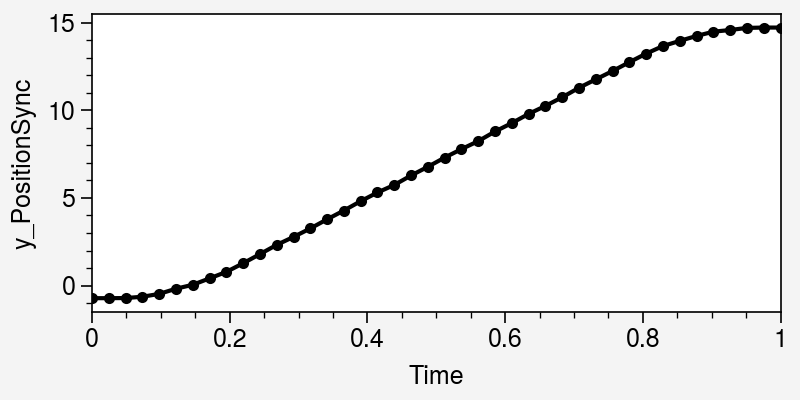

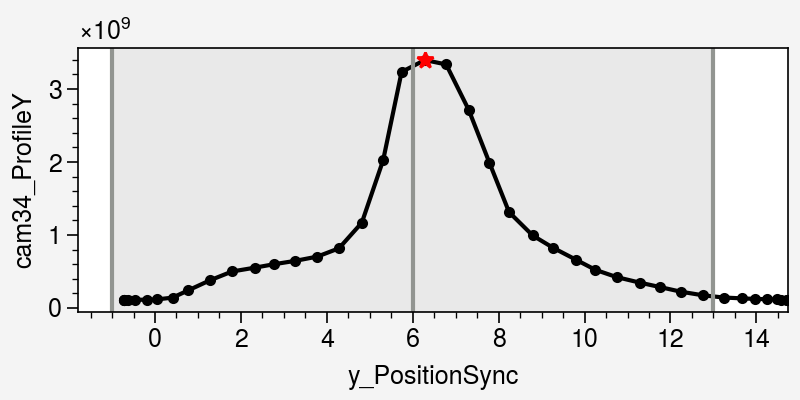

Peak at y_PositionSync = 6.282


In [28]:
y0 = 6.0
dy = 14.0

tdata = np.linspace(0.0, 1.0, len(data))

fig, ax = pplt.subplots(figsize=(4, 2))
#tpred = np.linspace(0,1,len(act1))
ax.plot(tdata, data[:, acts[0]], marker='.', color='black') #plt.plot(tpred,act3,':',color='C2')
ax.format(xlabel='Time', ylabel=acts[0])
plt.show()

fig, ax = pplt.subplots(nrows=1, figsize=(4, 2))
ax.plot(data[:, acts[0]], signal, marker='.', color='black')
ax.axvline(y0 - 0.5 * dy, color='grey')
ax.axvline(y0 + 0.5 * dy, color='grey')
ax.axvline(y0, color='grey')
ax.axvspan(y0 - 0.5 * dy, y0 + 0.5 * dy, color='grey', alpha=0.2)
imax = np.argmax(w)
ax.plot(data[imax, acts[0]], w[imax], marker='*', color='red')
ax.format(xlabel=acts[0], ylabel=cam_prof_y)
plt.show()

print(f'Peak at {acts[0]} = {data[imax, acts[0]]:.3f}')

## Plot images

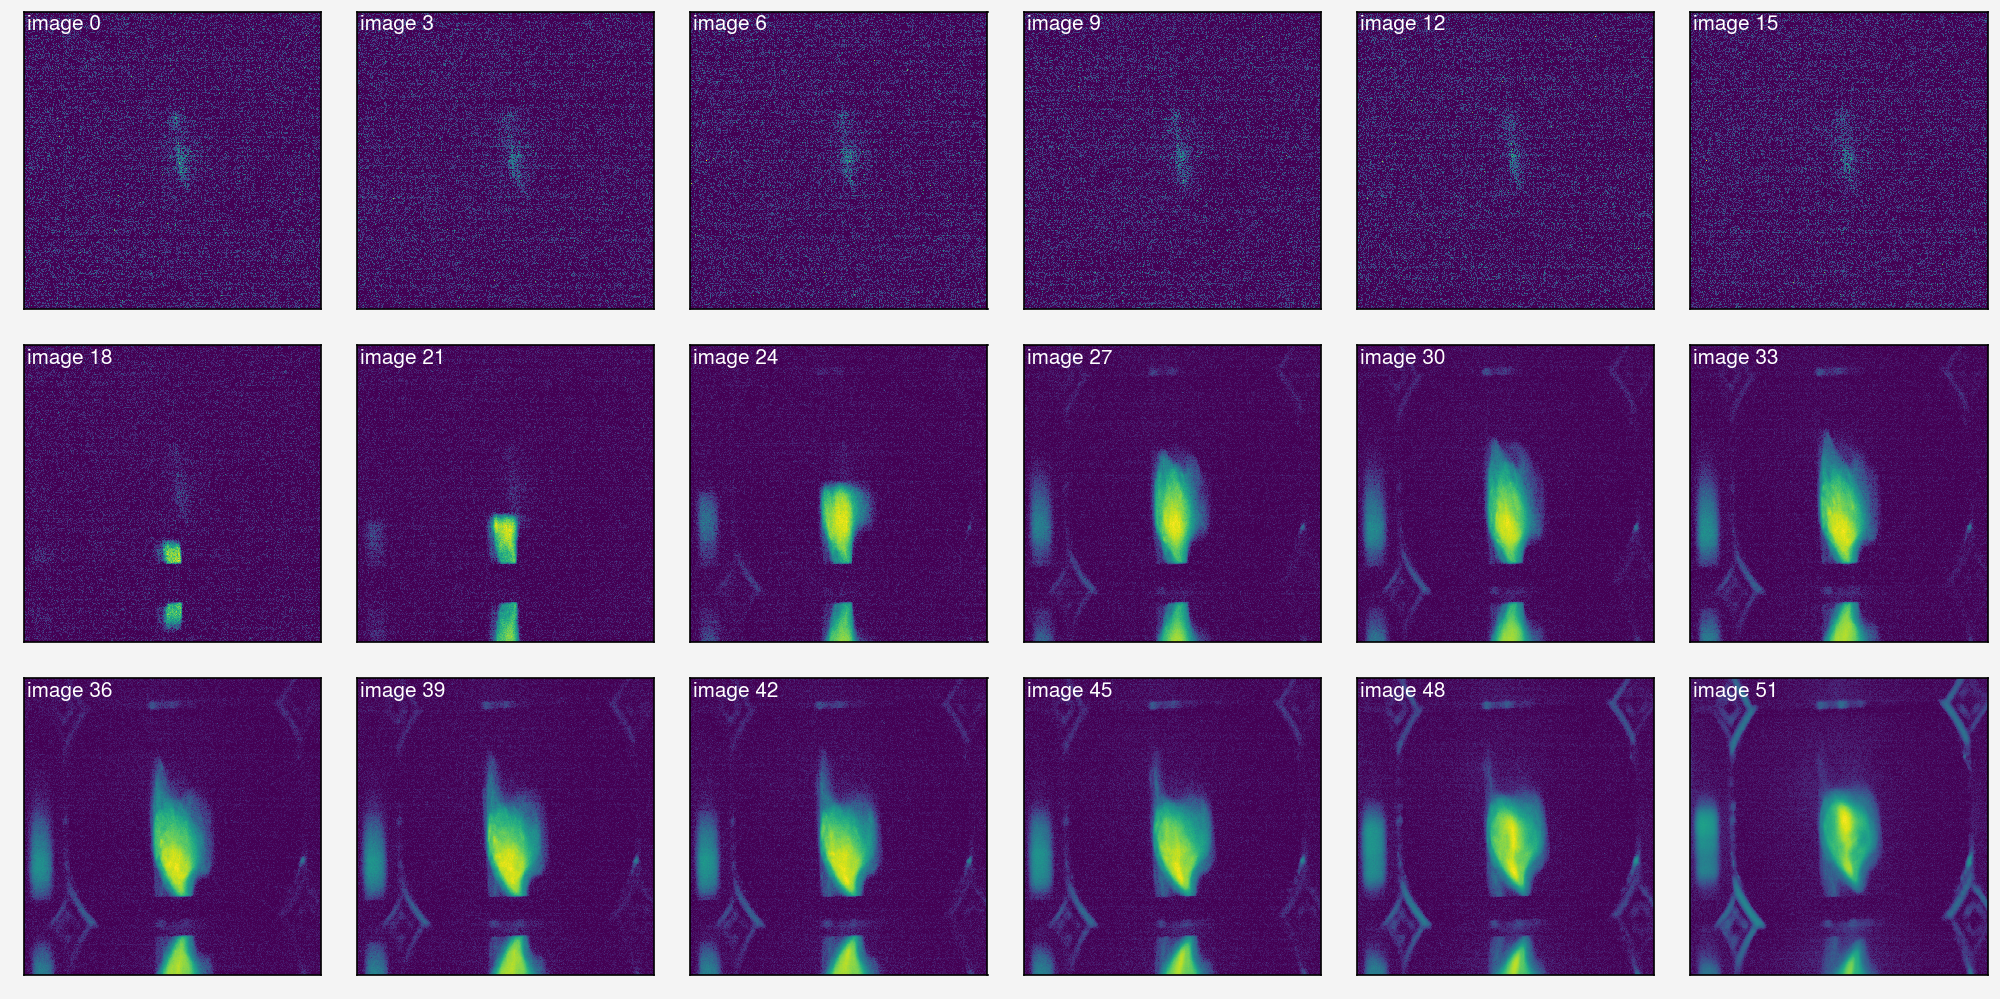

In [47]:
skip = 3
nfigs = len(data) // skip
ncols = 6
nrows = int(np.ceil(nfigs / ncol))

fig, axes = pplt.subplots(nrows=nrows, ncols=ncols, figwidth=10.0)
for i, ax in enumerate(axes):
    ima = np.reshape(data[i, cam_image], (ny, nx))
    ax.pcolormesh(np.log10(ima))
    ax.annotate(f'image {i * skip}', xy=(0.01, 0.99), xycoords='axes fraction', 
                color='white', fontsize='small',
                horizontalalignment='left', verticalalignment='top')
axes.format(xticks=[], yticks=[])
plt.show()

## Reconstruct phase space distribution

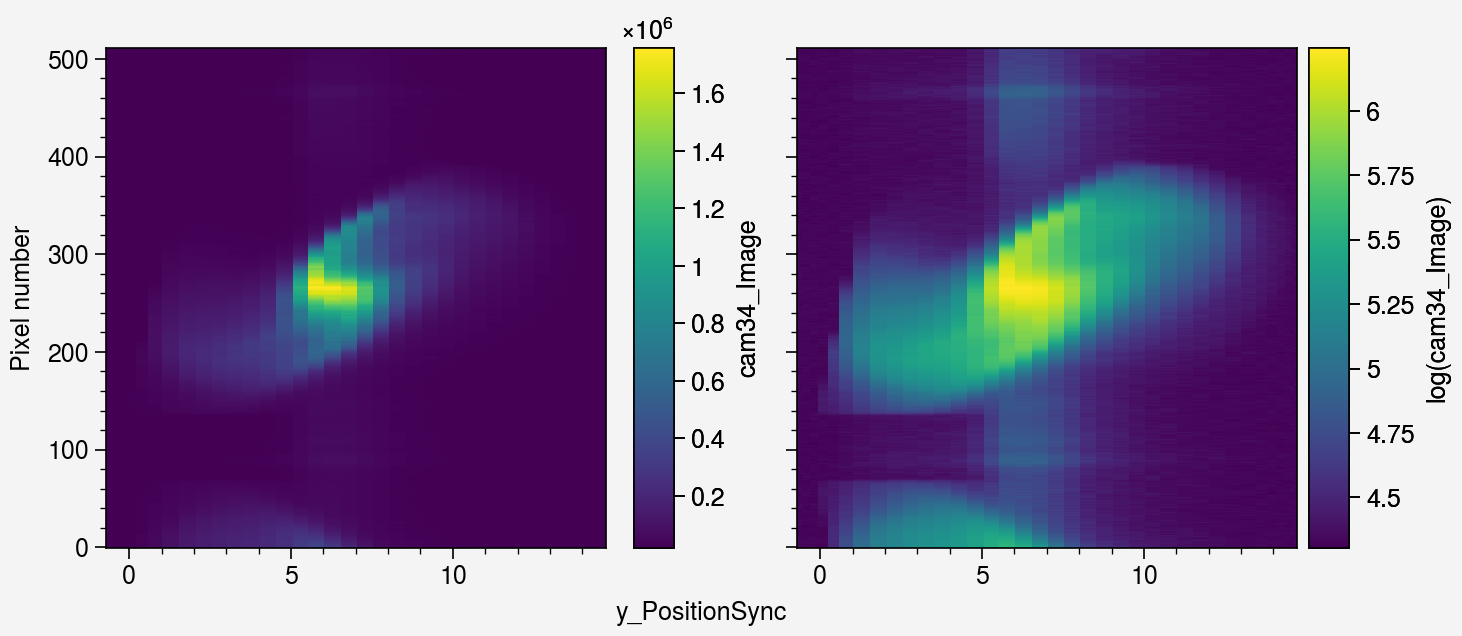

In [50]:
yyp = np.zeros([ny, len(data)])
for i in range(0, len(data)):
    im = np.reshape(data[i, cam_image], [ny, nx])
    yyp[:, i] = np.sum(im, axis=1)
    
fig, axes = pplt.subplots(ncols=2, sharey=True)
axes[0].pcolormesh(data[:, 'y_PositionSync'], np.arange(ny), yyp, 
                   colorbar=True, colorbar_kw=dict(label=cam_image))
axes[1].pcolormesh(data[:, 'y_PositionSync'], np.arange(ny), np.log10(yyp), 
                   colorbar=True, colorbar_kw=dict(label=f'log({cam_image})'))
axes.format(xlabel='y_PositionSync', ylabel='Pixel number')
plt.show()

The estimate of 0.09 pixels per mm is based on old camera calibration; this needs to be redone.

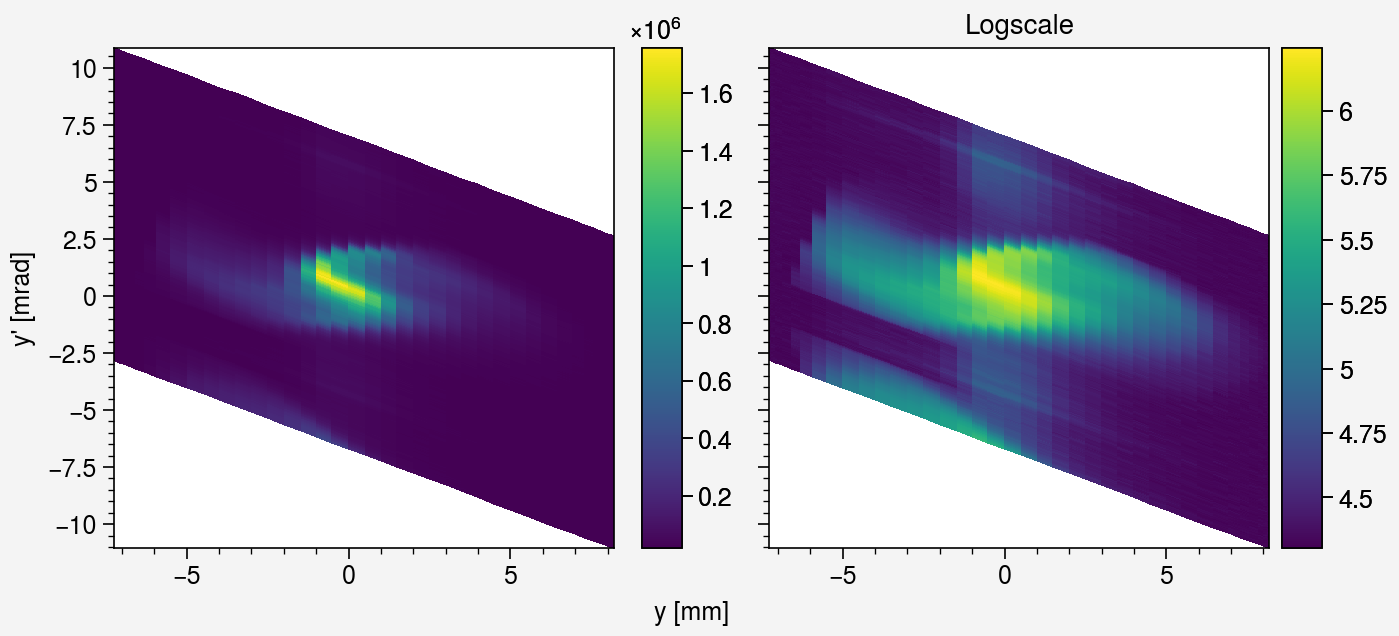

In [51]:
yscreen = pix2mm * np.arange(ny)  
Y1, Y2 = np.meshgrid(data[:, 'y_PositionSync'], yscreen)
Y = Y1 - np.average(data[:, 'y_PositionSync'], weights=np.sum(yyp, axis=0))
YP = (Y2 - np.average(yscreen, weights=np.sum(yyp, axis=1)) - Y) / L

fig, axes = pplt.subplots(ncols=2, sharey=True)
axes[0].pcolormesh(Y, YP, yyp, colorbar=True)
axes[1].pcolormesh(Y, YP, np.log10(yyp), colorbar=True)
axes.format(xlabel="y [mm]", ylabel="y' [mrad]")
axes[1].set_title('Logscale')
plt.show()

## Reconstruct phase space; energy slice

The y-y' phase space is already a slice in x-x' (near the beam center).

The yyp3d axes are y3, x3, y1.

In [52]:
yyp3d = np.zeros([ny, nx, len(data)])
for i in range(0, len(data)):
    yyp3d[:, :, i] = np.reshape(data[i, cam_image], (ny, nx))

# GIF

#### cam34 image vs y-slit

In [54]:
labeller = lambda x: '%.1f'%np.log10(x)
labeller = lambda x: f'{np.log10(x):.1f}'
contour_levels = tuple([10.0**i for i in [-4.0, -3.0, -2.0, -1.0]])
default_norm = colors.LogNorm(vmin=1e-4, vmax=1.0, clip=False)

def thisplot(array2plot, labels, norm=default_norm, ax1=None, ax2=None):
    try:
        plt.pcolor(ax1, ax2, array2plot)
    except:
        plt.pcolor(array2plot)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.colorbar()
    try:
        CS = plt.contour(ax1, ax2, array2plot / array2plot.max(), 
                         levels=contour_levels, norm=norm, cmap='Set1')
    except:
        CS = plt.contour(array2plot / array2plot.max(), 
                         levels=contour_levels, norm=norm, cmap='Set1')
    plt.clabel(CS, fmt=labeller)
    
def plot_image(image,log=False, nx_=nx, ny_=ny,norm=default_norm,labels=['',''],trace=True):
    xpx = np.arange(np.shape(image)[1])
    ypx = np.arange(np.shape(image)[0])
    sumima = image.sum().sum()
    profx = image.sum(axis=0) / sumima
    profy = image.sum(axis=1) / sumima
    if log:
        plt.pcolor(xpx, ypx, np.log10(image))
        if trace:
            plt.plot(xpx, 0.1 * ny_ * (3.0 + np.log10(profx / profx.max())), 'r')
            plt.plot(0.1 * nx_ * (3.0 + np.log10(profy / profy.max())), ypx, 'r')
        plt.ylim([0, ny_])
        plt.xlim([0, nx_])
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    else:  
        #thisplot(image,labels,ax1=xpx,ax2=ypx,norm=norm)
        plt.pcolor(xpx, ypx, image, shading='auto')
        if trace:
            plt.plot(xpx, ny_ * 0.2 * profx / profx.max(), 'w')
            plt.plot(1.0 + nx_ * 0.2 * profy / profy.max(), ypx, 'w')        

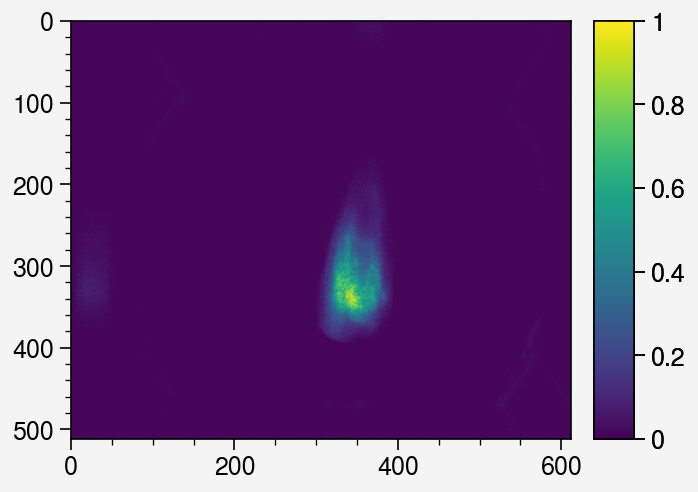

In [60]:
norm_pixel_value = np.max(data[:, cam_image])
images = []
greyscale = False
colormap = pplt.Colormap('viridis')
for i in range(len(data)):
    im = yyp3d[:, :, i]                              
    im = im / np.max(im)
    if greyscale:
        images.append(np.uint8(im * np.iinfo(np.uint8).max))
    else:
        im_rgb = colormap(im)
        images.append(np.uint8(im_rgb * np.iinfo(np.uint8).max))
    
imageio.mimsave('_output/' + filename + f'-{cam}-screen-unorm.gif', images, fps=3)
fig, ax = pplt.subplots()
ax.imshow(images[30], colorbar=True);

#### Slit/screen coordinates

In [61]:
x3 = np.arange(nx) * pix2mm
y3 = np.arange(ny) * pix2mm
y1 = data[:, 'y_PositionSync']

x3 = x3 - np.average(x3, weights=yyp3d.sum(axis=0).sum(axis=1))
# Negative signs flip y-slit and y-screen axes.
y3 = -1.0 * (y3 - np.average(y3, weights=yyp3d.sum(axis=1).sum(axis=1)))
y1 = -1.0 * (y1 - np.average(y1, weights=yyp3d.sum(axis=0).sum(axis=0)))
Y3, X3, Y1 = np.meshgrid(y3, x3, y1, indexing='ij')

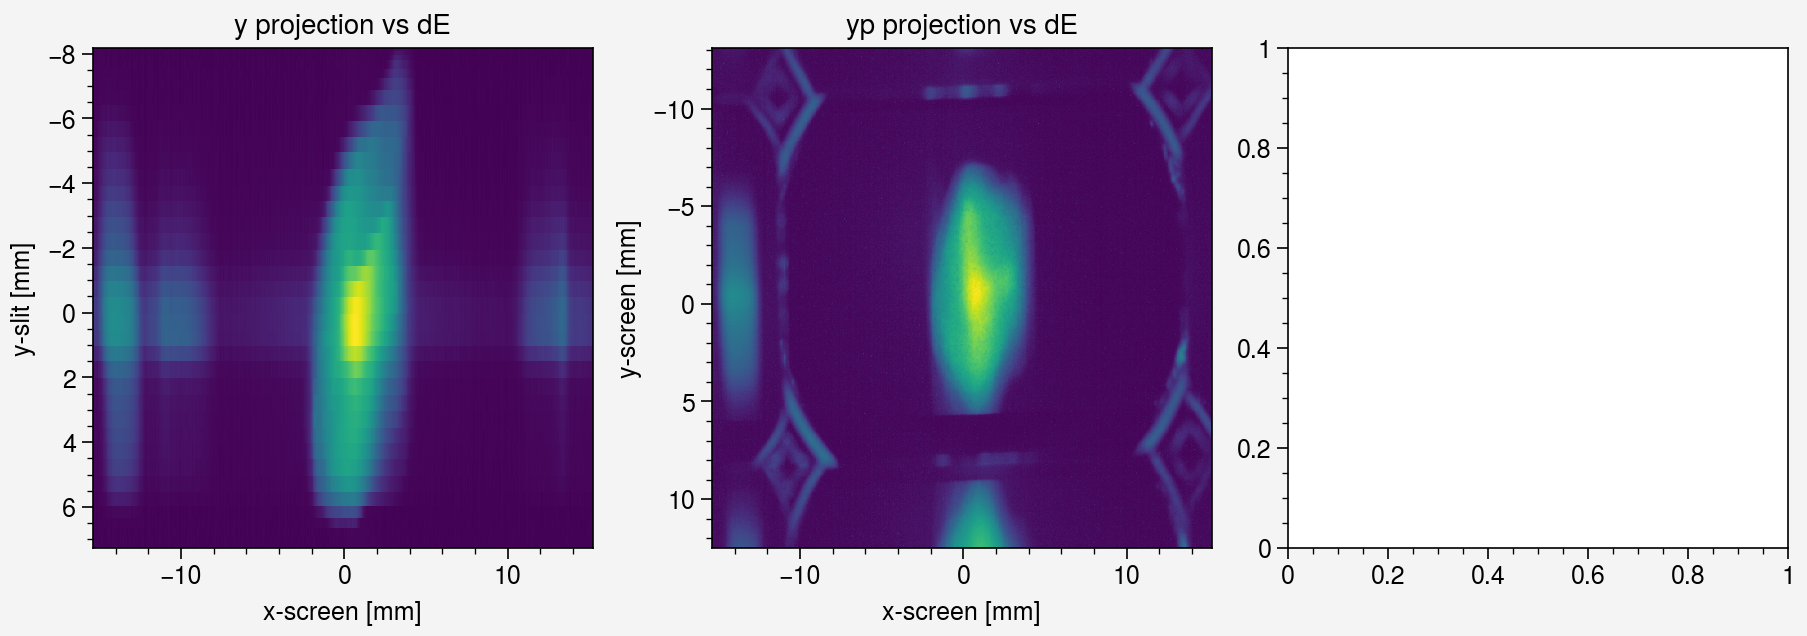

In [77]:
log = True
normalizer = colors.LogNorm if log else colors.Normalize

fig, axes = pplt.subplots(ncols=3, sharex=False, sharey=False)

H = yyp3d.sum(axis=0)
norm = normalizer(vmin=np.min(H), vmax=np.max(H))
axes[0].pcolormesh(x3, y1, H.T, norm=norm)
axes[0].format(xlabel='x-screen [mm]', ylabel='y-slit [mm]', title='y projection vs dE')

H = yyp3d.sum(axis=2)
norm = normalizer(vmin=np.min(H), vmax=np.max(H))
axes[1].pcolormesh(x3, y3, H, norm=norm)
axes[1].format(xlabel='x-screen [mm]', ylabel='y-screen [mm]', title='yp projection vs dE')

/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':
/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app
/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the s

Text(0, 0.5, 'y-screen [mm]')

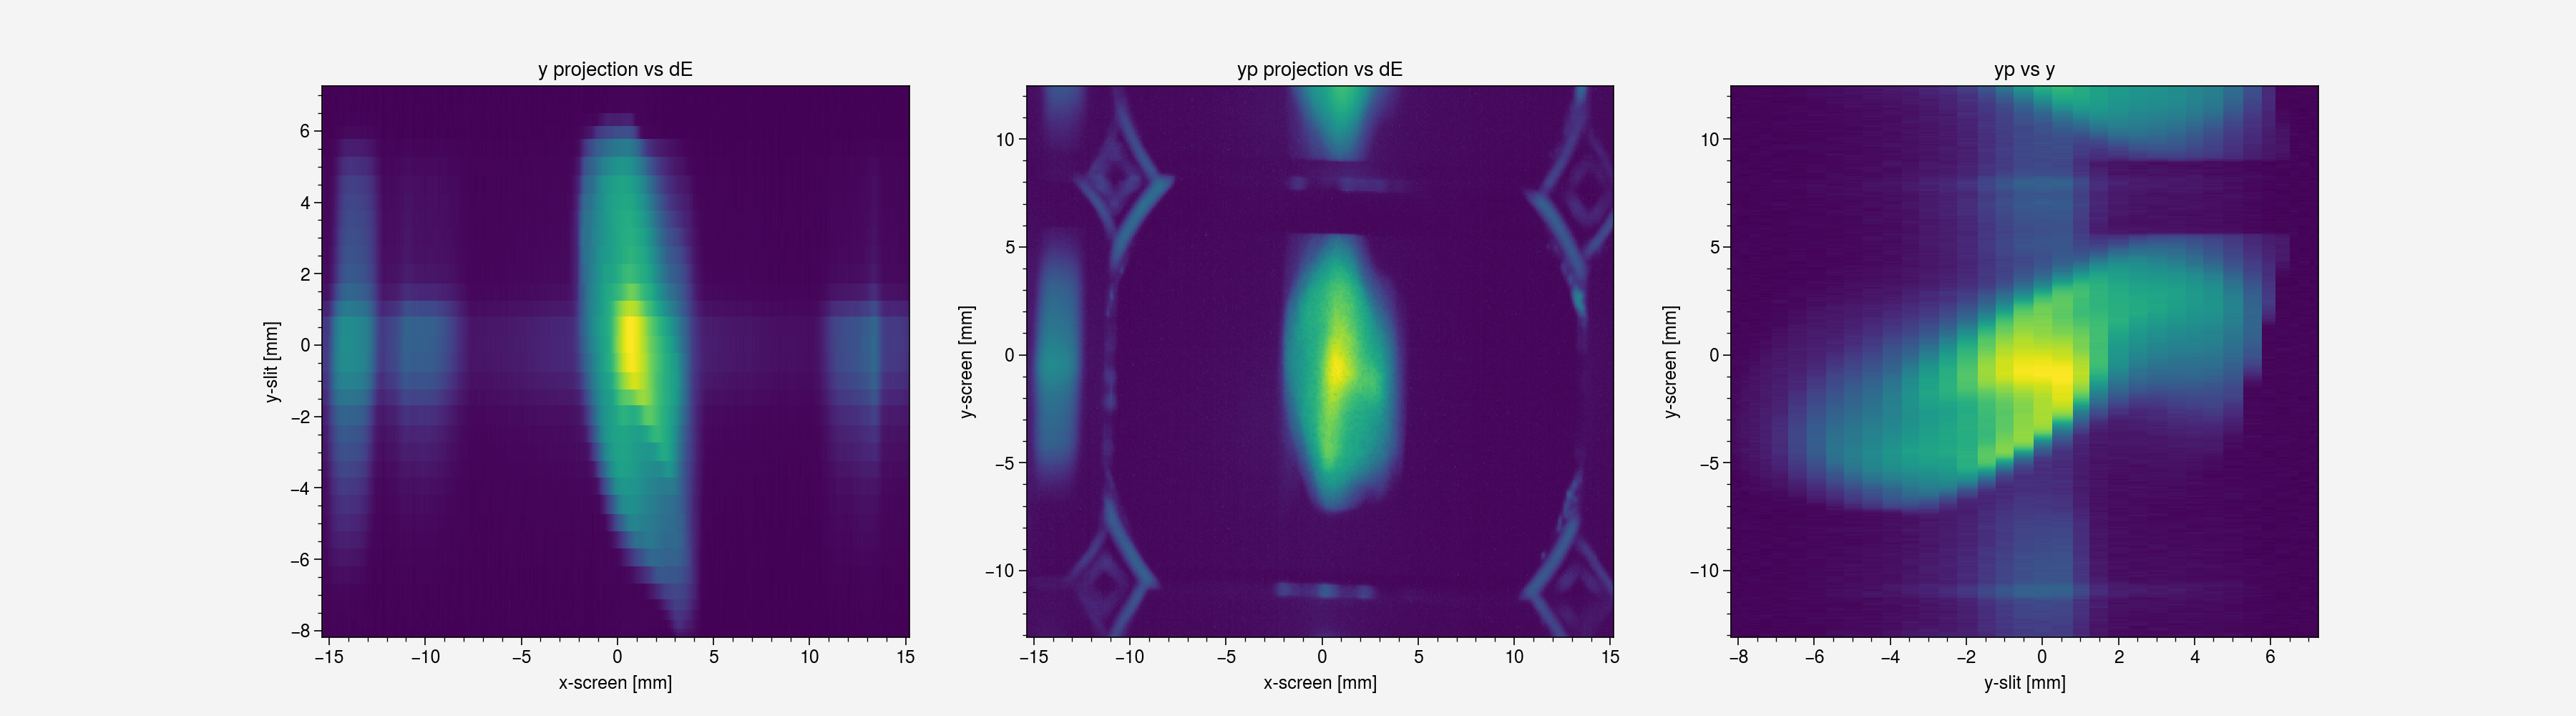

In [75]:
log = True
   
plt.figure(figsize=[18,5])
plt.subplot(131)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
plt.pcolor(x3,y1,yyp3d.sum(axis=0).T,norm=norm); plt.title('y projection vs dE'); plt.xlabel('x-screen [mm]'); plt.ylabel('y-slit [mm]')
plt.subplot(132)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=2).min(), vmax=yyp3d.sum(axis=2).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=2).min(), vmax=yyp3d.sum(axis=2).max())
plt.pcolor(x3,y3,yyp3d.sum(axis=2),norm=norm); plt.title('yp projection vs dE'); plt.xlabel('x-screen [mm]'); plt.ylabel('y-screen [mm]')
plt.subplot(133)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
plt.pcolor(y1,y3,yyp3d.sum(axis=1),norm=norm); plt.title('yp vs y'); plt.xlabel('y-slit [mm]'); plt.ylabel('y-screen [mm]')                                                                                  

In [ ]:
# -- matrix params
a2mm = 1.009 # assume same as first dipole
rho = 0.3556
GL05 = 0
GL06 = 0.0
l1 = 0
l2 = 0
l3 = 0.774
L2 = 0.311 # slit2 to dipole face
l = 0.129 # dipole face to VS06 screen (assume same for 1st and last dipole/screen)
LL = l1+l2+l3+L2 # distance from emittance plane to dipole entrance

ecalc = energy.energyCalculate(l1=l1,l2=l2,l3=l3,L2=L2,l=l,amp2meter=a2mm*1e3)

#Mslit = ecalc.getM1() # slit-slit
Mscreen = ecalc.getM2() # 2nd-slit to screen

## -- matrix mupltiply to get yp, w
## 3D grids
Y = Y1.copy()
YP = ecalc.calculate_yp(Y.flatten()*1e-3,Y3.flatten()*1e-3,Mscreen)
YP = YP.reshape(np.shape(Y))*1e3
W = ecalc.calculate_dE_screen(X3.flatten()*1e-3, 0, 0, 0, Mscreen)
W = W.reshape(np.shape(Y))*1e3

w = ecalc.calculate_dE_screen(x3*1e-3, 0, 0, 0, Mscreen)*1e3



In [ ]:
log = True
   
plt.figure(figsize=[12,5])
plt.subplot(121)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=0).min(), vmax=yyp3d.sum(axis=0).max())
plt.pcolor(W.mean(axis=0).T,Y.mean(axis=0).T,yyp3d.sum(axis=0).T,norm=norm); plt.title('y projection vs dE'); plt.xlabel('w [keV]'); plt.ylabel('y [mm]')
plt.subplot(122)
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
plt.pcolor(Y.mean(axis=1),YP.mean(axis=1),yyp3d.sum(axis=1),norm=norm); plt.title('yp vs y'); plt.xlabel('y [mm]'); plt.ylabel('yp [mrad]')
                                                                                                

In [ ]:
plt.plot(w,yyp3d.sum(axis=0).sum(axis=1))
#plt.semilogy()
plt.grid()

#### y-yp vs w

In [ ]:
idx = np.arange(150,520,1)
lidx = len(idx)
images = []

for i in range(lidx):
    
    ima = yyp3d[:,idx[i],:]
    # repeat columns to strech image
    ima = np.repeat(ima,7,1)
                              
    # -- normalize all frames in sweep to same pixel
    #ima = np.log10(ima) / np.log10(norm_pixel_value)
    #ima = np.log10(ima) / np.log10(np.max(ima))
    ima = ima/np.max(ima)
    #
    #ima = ima / np.max(ima)
    # BW
    #images.append(np.uint8(ima*np.iinfo(np.uint8).max))
    # color
    ima_rgb = cm.viridis(ima)
    img = np.uint8(ima_rgb*np.iinfo(np.uint8).max)   
    images.append(img)
    
imageio.mimsave(filename+'-vs-energy.gif', images, fps=30)


plt.imshow(images[30]); 
plt.colorbar()


## Make animation of y-yp phase space vs energy

In [ ]:
log=False
contour=True

fig, (ax1,ax2)= plt.subplots(1,2)
fig.set_tight_layout(True)
fig.set_dpi(300)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# initial plot
idxmax=np.argmax(yyp3d)
idxmax = np.unravel_index(idxmax,np.shape(yyp3d))
i=idxmax[1]



# left plot shows energy distribution at beam center (or integrated..choose which)
wprof = yyp3d[idxmax[0],:,idxmax[2]]#.sum(axis=0).sum(axis=1)
w_curve, = ax1.plot(w,wprof,'-'); 
w_point, = ax1.plot(w[i],wprof[i],'o',color='C0');
if log:
    ax1.semilogy()
ax1.set_ylabel('signal [a.u.]')
ax1.set_xlabel('w [keV]')

#right plot shows y-y' phase space

if log:
    norm=colors.LogNorm(vmin=yyp3d.min(), vmax=yyp3d.max())
else:
    norm=colors.Normalize(vmin=yyp3d.min(), vmax=yyp3d.max())
implot = ax2.pcolormesh(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],norm=norm)
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])
ax2.set_ylabel('y\' [mrad]')
ax2.set_xlabel('y [mm]')

# contours on right plot
labeller = lambda x: '%.1f'%np.log10(x)
contour_levels = tuple([10**i for i in [-4,-3,-2,-1]])
default_norm = colors.LogNorm(vmin=1e-4, vmax=1, clip=False)
if contour:
    ax2.contour(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:]/yyp3d[idxmax],levels=contour_levels,norm=default_norm,cmap='Set1')
#plt.clabel(CS,fmt = labeller)


def update(i):

    # left plot - move point
    w_point.set_ydata(wprof[i])
    w_point.set_xdata(w[i])

    # right plot -- update image
    #ax2.set_xdata(Y[:,i,:])
    # implot.set_paths(Y[:,i,:],YP[:,i,:])
    # implot.set_array(yyp3d[:,i,:])
    ax2.cla()
    ax2.pcolormesh(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],norm=norm)
    if contour:
        ax2.contour(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:]/yyp3d[idxmax],levels=contour_levels,norm=default_norm,cmap='Set1')
    ax2.set_xlim([-10,10])
    ax2.set_ylim([-10,10])
    ax2.set_ylabel('y\' [mrad]')
    ax2.set_xlabel('y [mm]')
        
    #axis.set_title(label)
    return w_point,ax2

# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
idx = np.arange(150,520,1)
anim = FuncAnimation(fig, update, frames=idx, interval=20)
anim.save('%s_yyp_vs_energy_linear.gif'%filename, dpi=300)#, writer='imagemagick')

## Calculate emittance

First, for projected emittance (still slice in x,x')

In [ ]:
log=False
if log:
    norm=colors.LogNorm(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())
else:
    norm=colors.Normalize(vmin=yyp3d.sum(axis=1).min(), vmax=yyp3d.sum(axis=1).max())

thr = 6.*np.median(yyp3d.sum(axis=1).flatten())
print('Thr at 10^%.2f fraction of peak'%np.log10(thr/yyp3d.sum(axis=1).max()))

i = idxmax[1]
plt.pcolormesh(Y.mean(axis=1),YP.mean(axis=1),yyp3d.sum(axis=1),norm=norm)
#plt.contour(Y.mean(axis=1),YP.mean(axis=1),yyp3d.sum(axis=1),levels=[thr],colors=['r'])
plt.ylim([-10,10])
plt.xlim([-10,10])

# emittance
weights = yyp3d.sum(axis=1)
weights[weights<thr] = 0
plt.contour(Y.mean(axis=1),YP.mean(axis=1),weights,levels=[thr],colors=['r'])
xc = np.average(Y.mean(axis=1),weights=weights)
sigxsq = np.average((Y.mean(axis=1)-xc)**2,weights=weights)
xpc = np.average(YP.mean(axis=1),weights=weights)
sigxpsq = np.average((YP.mean(axis=1)-xpc)**2,weights=weights)
sigxxp = np.average((Y.mean(axis=1)-xc)*(YP.mean(axis=1)-xpc),weights=weights)

emit0 = np.sqrt(sigxsq*sigxpsq - sigxxp**2)
bet0 = sigxsq/emit0
gam0 = sigxpsq/emit0
alph0 = np.sqrt(gam0*bet0-1)
sigx0 = np.sqrt(sigxsq)
sigxp0 = np.sqrt(sigxpsq)

print('Emittance: %.3f mm-mrad\nalpha = %.3f\nbeta = %.3f\ngamma = %.3f'%(emit0,alph0,bet0,gam0))
print('sigma x = %.3f mm\nsigma x\' = %.3f mrad'%(sigx0,sigxp0))

## Slice emittance

In [ ]:
log=False
if log:
    norm=colors.LogNorm(vmin=yyp3d.min(), vmax=yyp3d.max())
else:
    norm=colors.Normalize(vmin=yyp3d.min(), vmax=yyp3d.max())

thr = 7*np.median(yyp3d.flatten())
print('Thr at 10^%.2f fraction of peak'%np.log10(thr/yyp3d.max()))

i = idxmax[1]
plt.pcolormesh(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],norm=norm)
plt.contour(Y[:,i,:],YP[:,i,:],yyp3d[:,i,:],levels=[thr],colors=['r'])
plt.ylim([-10,10])
plt.xlim([-10,10])


In [ ]:
if log:
    norm=colors.LogNorm(vmin=yyp3d.min(), vmax=yyp3d.max())
else:
    norm=colors.Normalize(vmin=yyp3d.min(), vmax=yyp3d.max())

idx = np.arange(150,520,1)
emit,alph,bet,gam,sigx,sigxp = np.zeros([6,len(idx)])
for i in range(len(idx)):
    
    weights = yyp3d[:,idx[i],:].copy()
    weights[weights<thr] = 0
    if np.sum(weights) > 0:
        xc = np.average(Y[:,idx[i],:],weights=weights)
        sigxsq = np.average((Y[:,idx[i],:]-xc)**2,weights=weights)
        xpc = np.average(YP[:,idx[i],:],weights=weights)
        sigxpsq = np.average((YP[:,idx[i],:]-xpc)**2,weights=weights)
        sigxxp = np.average((Y[:,idx[i],:]-xc)*(YP[:,idx[i],:]-xpc),weights=weights)

        emit[i] = np.sqrt(sigxsq*sigxpsq - sigxxp**2)
        bet[i] = sigxsq/emit[i]
        gam[i] = sigxpsq/emit[i]
        alph[i] = np.sqrt(gam[i]*bet[i]-1)
        sigx[i] = np.sqrt(sigxsq )
        sigxp[i] = np.sqrt(sigxpsq )

In [ ]:
plt.figure()
plt.plot(w[idx],emit); plt.ylim([0,5]); plt.grid()
plt.plot(plt.xlim(),[emit0,emit0])
plt.xlabel('w [keV]')
plt.ylabel('rms y emittance [mm-mrad, unnorm.]')

plt.figure()
plt.plot(w[idx],sigx); plt.ylim([0,3]); plt.grid()
plt.plot(plt.xlim(),[sigx0,sigx0])
plt.xlabel('w [keV]')
plt.ylabel('rms y [mm]')

plt.figure()
plt.plot(w[idx],sigxp); plt.ylim([0,3]);  plt.grid()
plt.plot(plt.xlim(),[sigxp0,sigxp0])
plt.xlabel('w [keV]')
plt.ylabel('rms y\' [mrad]')

plt.figure()
plt.plot(w[idx],alph); plt.ylim([-.1,.5]);  plt.grid()
plt.plot(plt.xlim(),[alph0,alph0])
plt.xlabel('w [keV]')
plt.ylabel('rms alpha')

plt.figure()
plt.plot(w[idx],bet); plt.grid()
plt.plot(plt.xlim(),[bet0,bet0])
plt.xlabel('w [keV]')
plt.ylabel('rms beta [m]')

plt.figure()
plt.plot(w[idx],gam); plt.ylim([0,1.5]);   plt.grid()
plt.plot(plt.xlim(),[gam0,gam0])
plt.xlabel('w [keV]')
plt.ylabel('rms gamma')